In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 5
fig_height = 4
fig_format = :png
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/run/media/alf/datos/misrepositorios/docencia/analisis-practicas-julia"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using SymPy  # Para el cálculo simbólico de límites.
using Plots  # Para el dibujo de gráficas.
#plotlyjs() # Para obtener gráficos interactivos.
using ImplicitPlots # Para dibujar curvas implícitas.
using MTH229 # Para restringir la gráfica de una función a su dominio.
using LaTeXStrings  # Para usar código LaTeX en los gráficos.
using Latexify  # Para convertir expresiones a código LaTeX.

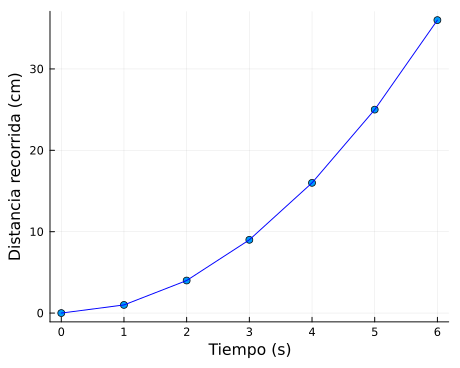

In [3]:
using Plots
t = [0, 1, 2, 3, 4, 5, 6]
d = [0, 1, 4, 9, 16, 25, 36]
Plots.scatter(t, d, legend=false)
plt = Plots.plot!(t, d, linecolor="blue", xlab="Tiempo (s)", ylab="Distancia recorrida (cm)")

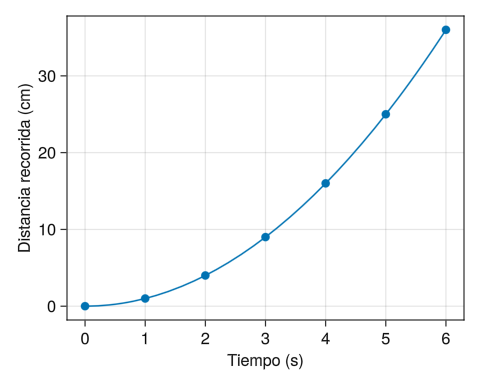

In [4]:
using GLMakie
t = [0, 1, 2, 3, 4, 5, 6]
d = [0, 1, 4, 9, 16, 25, 36]
fig = Figure()
ax = Axis(fig[1,1], xlabel="Tiempo (s)", ylabel="Distancia recorrida (cm)")
Makie.scatter!(ax, t, d)
f(x) = x^2
Makie.lines!(ax, 0..6, f)
fig

Velocidad media desde el instante 0 al instante 3: 3.0 cm/s
Velocidad media desde el instante 1 al instante 3: 4.0 cm/s
Velocidad media desde el instante 2 al instante 3: 5.0 cm/s


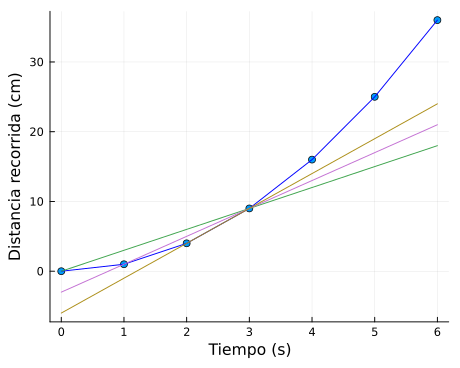

In [5]:
# Función para el cálculo de la velocidad media en del instante i al instante j.
tvm(i, j) = (d[j]-d[i])/(t[j]-t[i])
j = 4
# Cálculo de las velocidades medias.
for i in 1:3
    println("Velocidad media desde el instante $(t[i]) al instante $(t[j]): $(tvm(i, j)) cm/s")
end
# Función para calcular la ecuación de la recta secante en los instantes i y j.
secante(x, i, j) = d[i] + tvm(i, j) * (x - t[i])
# Dibujo de las rectas secantes
for i in 1:3
    plt = Plots.plot!(x -> secante(x,i,j))
end
plt

Velocidad media desde el instante 3 al instante 6: 9.0 cm/s
Velocidad media desde el instante 3 al instante 5: 8.0 cm/s
Velocidad media desde el instante 3 al instante 4: 7.0 cm/s


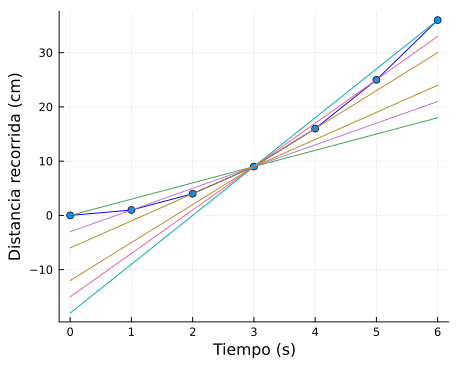

In [6]:
i = 4
# Cálculo de las velocidades medias.
for j in 7:-1:5
    println("Velocidad media desde el instante $(t[i]) al instante $(t[j]): $(tvm(i, j)) cm/s")
end
# Dibujo de las rectas secantes.
for j in 7:-1:5
    plt = Plots.plot!(x -> secante(x,i,j))
end
plt

In [7]:
v = []
for i in 2:length(d)
    push!(v, d[i]-d[i-1])
    println("Velocidad media desde el instante $(t[i-1]) al instante $(t[i]): $(v[i-1]) cm/s")
end

Velocidad media desde el instante 0 al instante 1: 1 cm/s
Velocidad media desde el instante 1 al instante 2: 3 cm/s
Velocidad media desde el instante 2 al instante 3: 5 cm/s
Velocidad media desde el instante 3 al instante 4: 7 cm/s
Velocidad media desde el instante 4 al instante 5: 9 cm/s
Velocidad media desde el instante 5 al instante 6: 11 cm/s


In [8]:
for i in 2:length(v)
    println("Aceleración media desde el instante $(t[i-1]) al instante $(t[i]): $(v[i]-v[i-1]) cm/s")
end

Aceleración media desde el instante 0 al instante 1: 2 cm/s
Aceleración media desde el instante 1 al instante 2: 2 cm/s
Aceleración media desde el instante 2 al instante 3: 2 cm/s
Aceleración media desde el instante 3 al instante 4: 2 cm/s
Aceleración media desde el instante 4 al instante 5: 2 cm/s


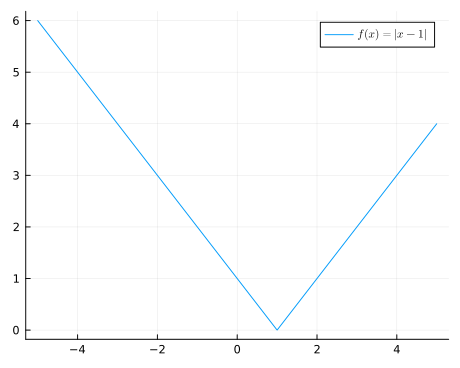

Derivada por la izquierda: -1
Derivada por la derecha: 1


In [9]:
using Plots, SymPy, LaTeXStrings
@syms x::real
f(x) = abs(x-1)
display(Plots.plot(f(x), label=L"f(x)=|x-1|"))
println("Derivada por la izquierda: ", limit((f(x)-f(1))/(x-1), x=>1, dir="-"))
println("Derivada por la derecha: ", limit((f(x)-f(1))/(x-1), x=>1, dir="+"))

In [10]:
using SymPy
@syms x::real
f(x) = log(x+1)
println("Primera derivada: ", diff(f))
println("Segunda derivada: ", diff(f,2))
println("Tercera derivada: ", diff(f,3))
println("Cuarta derivada: ", diff(f,4))

Primera derivada: 1/(x + 1)
Segunda derivada: 

-1/(x + 1)^2
Tercera derivada: 2/(x + 1)^3
Cuarta derivada: -6/(x + 1)^4


In [11]:
using SymPy
@syms x::real a::real
g(x) = a^x
println("Primera derivada: ", diff(g(x), x))
println("Segunda derivada: ", diff(g(x), x, 2))
println("Tercera derivada: ", diff(g(x), x, 3))
println("Cuarta derivada: ", diff(g(x), x, 4))

Primera derivada: a^x*log(a)
Segunda derivada: a^x*log(a)^2
Tercera derivada: a^x*log(a)^3
Cuarta derivada: a^x*log(a)^4


In [12]:
using SymPy
@syms x::real
h(x) = sin(x)+cos(x)
println("Primera derivada: ", diff(h))
println("Segunda derivada: ", diff(h,2))
println("Tercera derivada: ", diff(h,3))
println("Cuarta derivada: ", diff(h,4))

Primera derivada: -sin(x) + cos(x)
Segunda derivada: -(sin(x) + cos(x))
Tercera derivada: sin(x) - cos(x)
Cuarta derivada: sin(x) + cos(x)


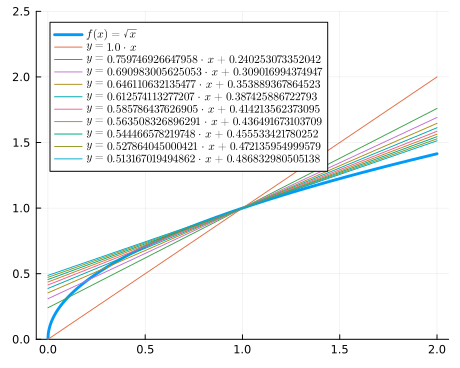

In [13]:
using Plots, SymPy, LaTeXStrings, Latexify
@syms x::real
f(x) = sqrt(x)
plt = Plots.plot(f, 0, 2, ylims=(0,2.5), linewidth = 3, label=L"f(x)=\sqrt{x}", legend=:topleft)
secante(x, i, j) = f(i) + (f(j)-f(i))/(j-i) * (x - i)
for i in 0:9
    sec = secante(x, i/10, 1)
    plt = Plots.plot!(sec, label =L"y=" * latexify(sec))
end
plt

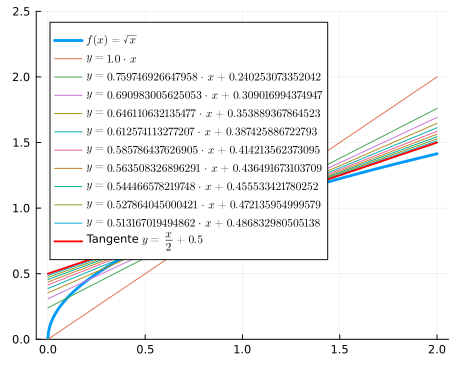

In [14]:
tg = f(1) + diff(f)(1) * (x-1)
Plots.plot!(tg, linewidth = 2, color = "red", label="Tangente " * L"y=" * latexify(tg))

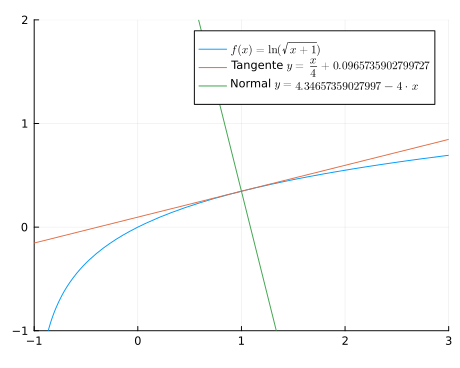

In [15]:
using Plots, SymPy, LaTeXStrings, Latexify
@syms x::real
f(x) = log(sqrt(x+1))
Plots.plot(f, -1, 3, xlims=(-1,3), ylims=(-1,2), aspect_ratio=1, label=L"f(x)=\ln(\sqrt{x+1})", legend=:topright)
tg = f(1) + diff(f)(1) * (x-1)
Plots.plot!(tg, label="Tangente "*L"y="*latexify(tg))
nm = f(1) - 1/diff(f)(1) * (x-1)
Plots.plot!(nm, label="Normal "*L"y="*latexify(nm))

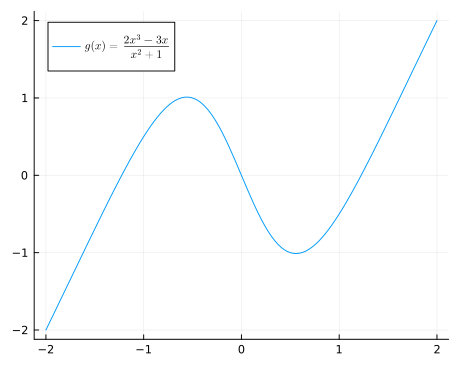

In [16]:
using Plots, SymPy, LaTeXStrings, Latexify
@syms x::real
g(x) = (2x^3-3x) / (x^2+1)
Plots.plot(g, -2, 2, label=L"g(x)=\frac{2x^3-3x}{x^2+1}", legend=:topleft)

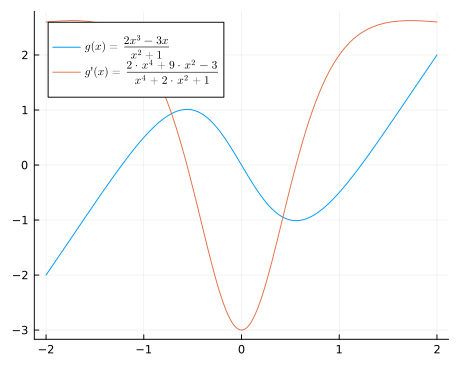

In [17]:
Plots.plot!(diff(g), label=L"g'(x)="*latexify(simplify(diff(g))))

In [18]:
N.(solve(diff(g)))

4-element Vector{Number}:
    -0.5583347485961263326654828454569561179259924185641573901331644861659481412422448
     0.5583347485961263326654828454569561179259924185641573901331644861659481412422448
 0.0 - 2.193567343732555569019661050002362205421503627733216097530210072083854926923076im
 0.0 + 2.193567343732555569019661050002362205421503627733216097530210072083854926923076im

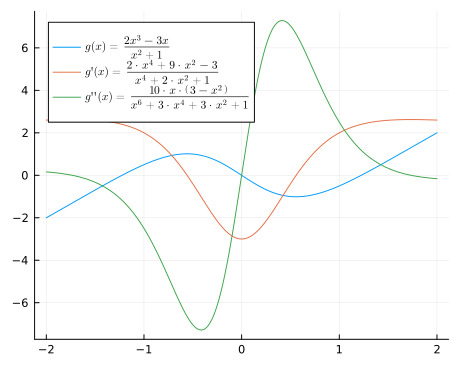

In [19]:
Plots.plot!(diff(g,2), label=L"g''(x)="*latexify(simplify(diff(g(x),x,2))))

In [20]:
N.(solve(diff(g,2)))

3-element Vector{Real}:
  0
 -1.732050807568877293527446341505872366942805253810380628055806979451933016908798
  1.732050807568877293527446341505872366942805253810380628055806979451933016908798

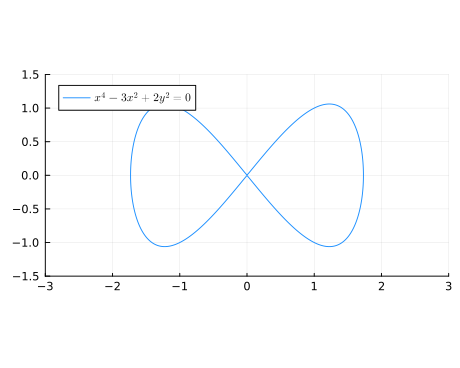

In [21]:
using ImplicitPlots, Plots, SymPy, LaTeXStrings, Latexify
@syms x::real y::real
f(x,y) = x^4 - 3x^2 + 2y^2
implicit_plot(f; xlims=(-3,3), ylims=(-1.5,1.5), label=L"x^4-3x^2+2y^2=0", legend=:topleft)

In [22]:
# Declaramos una función simbólica
@syms u()
# Reemplazamos y por una función simbólica u(x).
ex1 = subs(f(x,y), y=>u(x))
# Calculamos la derivada de ambos lados de la ecuación y la resolvemos para la derivada de u'(x).
du = solve(diff(ex1, x), diff(u(x), x))[1]
# Deshacemos el cambio y = u(x).
dy = subs(du, u(x) => y)
println("y'=", dy)

y'=x*(3 - 2*x^2)/(2*y)


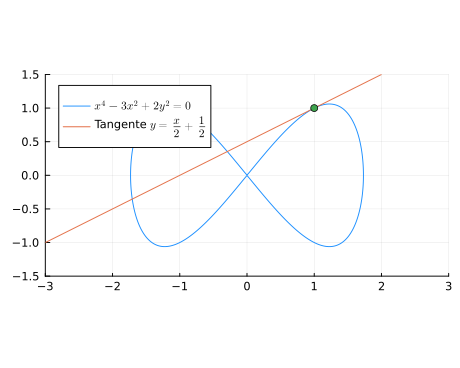

In [23]:
using Latexify
# Definimos la funciónd de la recta tangente
tg = 1 + dy(1,1) * (x-1)
Plots.plot!(tg, label="Tangente "*L"y="*latexify(tg))
# Dibujamos el punto (1,1)
Plots.scatter!([1],[1], label="")

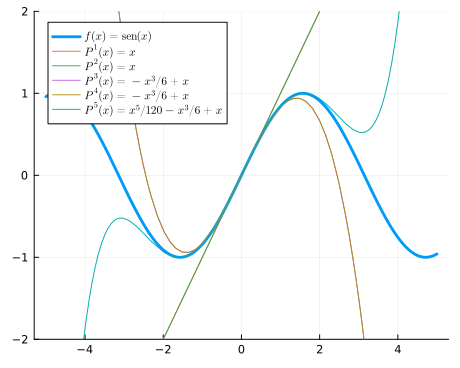

In [24]:
using Plots, SymPy, LaTeXStrings, Latexify
@syms x::real

function taylor(f, a=0, n=2)
    sum(diff(f, x, i)(a) / factorial(i) * (x-a)^i for i=0:n)
end

f(x) = sin(x)
plt = Plots.plot(f, ylims=(-2,2), linewidth=3, label=L"f(x)=\operatorname{sen}(x)")

for i in 1:5
    pol = taylor(f(x), 0, i)
    plt = Plots.plot!(pol, label=latexstring("P^{$(i)}(x)=$(pol)"))
end 
plt

In [25]:
using SymPy
@syms x::real
f(x) = cos(x)
SymPy.series(f(x), x, Sym(pi)/2, 11)

           3          5          7          9                          
    ⎛    π⎞    ⎛    π⎞    ⎛    π⎞    ⎛    π⎞                           
    ⎜x - ─⎟    ⎜x - ─⎟    ⎜x - ─⎟    ⎜x - ─⎟         ⎛       11       ⎞
π   ⎝    2⎠    ⎝    2⎠    ⎝    2⎠    ⎝    2⎠         ⎜⎛    π⎞        π⎟
─ + ──────── - ──────── + ──────── - ──────── - x + O⎜⎜x - ─⎟  ; x → ─⎟
2      6         120        5040      362880         ⎝⎝    2⎠        2⎠

In [26]:
g(x) = log(x)
SymPy.series(g(x), x, 1, 10)

            2          3          4          5          6          7          
     (x - 1)    (x - 1)    (x - 1)    (x - 1)    (x - 1)    (x - 1)    (x - 1)
-1 - ──────── + ──────── - ──────── + ──────── - ──────── + ──────── - ───────
        2          3          4          5          6          7          8   

8          9                          
    (x - 1)         ⎛       10       ⎞
─ + ──────── + x + O⎝(x - 1)  ; x → 1⎠
       9                              

In [27]:
h(x) = exp(sin(x))
SymPy.series(h(x), x, 0, 10)

         2    4    5     6    7       8     9          
        x    x    x     x    x    31⋅x     x      ⎛ 10⎞
1 + x + ── - ── - ── - ─── + ── + ───── + ──── + O⎝x  ⎠
        2    8    15   240   90    5760   5670         

In [28]:
using SymPy
@syms x::real
f(x) = log(1+x)
pol = SymPy.series(f(x), x, 0, 6).removeO()
println("Aproximación de ln(1.2): ", N(pol(0.2)))

Aproximación de ln(1.2): 0.18233066666666667


In [29]:
resto = diff(f, 6) / factorial(6) * 0.2^6
println("Resto de Taylor de orden 6: ", resto)
println("Derivada del resto : ", diff(resto))

Resto de Taylor de orden 6: -1.06666666666667e-5/(x + 1)^6
Derivada del resto : 6.4e-5/(x + 1)^7


In [30]:
println("Cota del error: " , maximum(N(abs.([resto(0), resto(0.2)])))) 
println("Error: ", abs(log(1.2)-pol(0.2)))

Cota del error: 1.066666666666667e-5
Error: 9.10987271207642e-6


In [31]:
println("Primera derivada: ", diff(f))
println("Segunda derivada: ", diff(f, 2))
println("Tercera derivada: ", diff(f, 3))
println("Cuarta derivada: ", diff(f, 4))

Primera derivada: 1/(x + 1)
Segunda derivada: -1/(x + 1)^2
Tercera derivada: 2/(x + 1)^3
Cuarta derivada: -6/(x + 1)^4


In [32]:
n=6
while 0.2^(n+1) / (n*(n+1)) > 10^-10
    n += 1
end
print(n)

11

In [33]:
#| echo: false
using QuizQuestions
nothing

In [34]:
#| echo: false
using SymPy
@syms x::real a::real b::real c::real
f1(x) = sin(x)^2
f2(x) = a*x^2+b
f3(x) = log(x)
nonlinsolve([limit(f1, 0, dir="-") - limit(f2, 0, dir="+"),limit(f2(x), x, c, dir="-") - limit(f3, c, dir="+")], (a,b,c))
solve(limit(f1, 0, dir="-") - limit(f2, 0, dir="+"))
solve(limit(f2(x), x, c, dir="-") - limit(f3, c, dir="+"))[1]
choices = (L"a=\sqrt{e}, b=0, c=\frac{1}{e}.", L"a=\frac{1}{2e}, b=0, c=e^{1/2}.", L"a=1, b=1, c=1.", L"a=1, b=0, c=e.", "Para ningún valor.")
answer = 2
radioq(choices, answer)

QuizQuestions.Radioq((L"$a=\frac{1}{2e}, b=0, c=e^{1/2}.$", L"$a=\sqrt{e}, b=0, c=\frac{1}{e}.$", "Para ningún valor.", L"$a=1, b=0, c=e.$", L"$a=1, b=1, c=1.$"), 1, [1, 2, 3, 4, 5], (L"$a=\frac{1}{2e}, b=0, c=e^{1/2}.$", L"$a=\sqrt{e}, b=0, c=\frac{1}{e}.$", "Para ningún valor.", L"$a=1, b=0, c=e.$", L"$a=1, b=1, c=1.$"), "", "", "", false)

In [35]:
#| echo: false
using SymPy
@syms x::real
f(x) = 1/sqrt(x+1)
diff(f,1)
diff(f,2)
diff(f,3)
diff(f,4)
choices = (L"\frac{(-1)^n n!}{2^n}(x+1)^{-n/2}.", L"\frac{(-1)^n (2n-1)!}{2^n}(x+1)^{-(2n-1)/2}.",L"\frac{(-1)^n \prod_{i=1}^n 2i}{2^n}(x+1)^{-(2n+1)/2}.", L"\frac{(-1)^n \prod_{i=1}^n 2i-1}{2^n}(x+1)^{-(2n+1)/2}.",  L"\frac{(-1)^n \prod_{i=1}^n 2i+1}{2^n}(x+1)^{-(2n+1)/2}.")
answer = 4
radioq(choices, answer)

QuizQuestions.Radioq((L"$\frac{(-1)^n \prod_{i=1}^n 2i+1}{2^n}(x+1)^{-(2n+1)/2}.$", L"$\frac{(-1)^n (2n-1)!}{2^n}(x+1)^{-(2n-1)/2}.$", L"$\frac{(-1)^n \prod_{i=1}^n 2i-1}{2^n}(x+1)^{-(2n+1)/2}.$", L"$\frac{(-1)^n \prod_{i=1}^n 2i}{2^n}(x+1)^{-(2n+1)/2}.$", L"$\frac{(-1)^n n!}{2^n}(x+1)^{-n/2}.$"), 3, [1, 2, 3, 4, 5], (L"$\frac{(-1)^n \prod_{i=1}^n 2i+1}{2^n}(x+1)^{-(2n+1)/2}.$", L"$\frac{(-1)^n (2n-1)!}{2^n}(x+1)^{-(2n-1)/2}.$", L"$\frac{(-1)^n \prod_{i=1}^n 2i-1}{2^n}(x+1)^{-(2n+1)/2}.$", L"$\frac{(-1)^n \prod_{i=1}^n 2i}{2^n}(x+1)^{-(2n+1)/2}.$", L"$\frac{(-1)^n n!}{2^n}(x+1)^{-n/2}.$"), "", "", "", false)

In [36]:
#| echo: false
using SymPy
@syms x::real
#f(x) = log(sqrt(x^2/2))
f(x) = 1/2*(log(x^2)-log(2))
g(x) = x^3+x^2-1
sol = solve(-1/diff(f(x))-diff(g(x)),x)[1]
numericq(sol, 1e-15)

QuizQuestions.Numericq(-1.00000000000000, 1.0e-15, "", "", "", "", nothing)

In [37]:
#| echo: false
using SymPy
@syms x::real
g(x) = sqrt(x^4-3x^3+2.5x^2)
raices = solve(diff(g(x)))
min = N(minimum(g.(vcat(-0.5, 0, raices, 1.5))))
numericq(min, 1e-5)

QuizQuestions.Numericq(0, 1.0e-5, "", "", "", "", nothing)

In [38]:
#| echo: false
max = N(maximum(g.(vcat(-0.5, 0, raices, 1.5))))
numericq(max, 1e-5)

QuizQuestions.Numericq(1.0307764064044151, 1.0e-5, "", "", "", "", nothing)

In [39]:
#| echo: false
using SymPy
@syms x::real
h(x) = (x^2+1)/exp(x)
solve(diff(h))
solve(diff(h,2))
choices = (L"Tiene un máximo en $x=1$.", L"Tiene un punto de inflexión en $x=3$.", L"Es decreciente en todo $\mathbb{R}$.", L"Es cóncava hacia abajo en $(1,3)$.", L"Tiene un mínimo en $x=1$.")
answers = [2,4]
multiq(choices, answers)

QuizQuestions.Multiq((L"Tiene un máximo en $x=1$.", L"Tiene un punto de inflexión en $x=3$.", L"Tiene un mínimo en $x=1$.", L"Es cóncava hacia abajo en $(1,3)$.", L"Es decreciente en todo $\mathbb{R}$."), [2, 4], [1, 2, 3, 4, 5], (L"Tiene un máximo en $x=1$.", L"Tiene un punto de inflexión en $x=3$.", L"Tiene un mínimo en $x=1$.", L"Es cóncava hacia abajo en $(1,3)$.", L"Es decreciente en todo $\mathbb{R}$."), "", "", "", false)

In [40]:
#| echo: false
using Plots, SymPy, ImplicitPlots
@syms x::real y::real a::real b::real l::real
@syms u()
f(x, y, a, b) = sqrt(x^2 + y^2) + sqrt((a-x)^2 + (b-y)^2)
eqn = f(x,y,a,b) - l
eqn_1 = diff(eqn(y => u(x)), x)
eqn_2 = solve(eqn_1, diff(u(x), x))[1]
dydx  = eqn_2(u(x) => y)
cps = solve(dydx, x)
eqn1 = eqn(x => cps[2])
ysol = N(solve(eqn1(a=>3, b=>2, l=>10), y))[1]
xsol = N(cps[2](y=>ysol, a=>3, b=>2, l=>10))
#tl(x) = ysol + 0 * (x- xsol)
#implicit_Plots.plot((x,y)->f(x,y,3,3) - 10, xlims=(-4, 7), ylims=(-10, 10))
#Plots.plot!(tl)
numericq(xsol, 1e-5)

QuizQuestions.Numericq(-3.398979485566356196394568149411782783931894961313340256865385134501920754915012, 1.0e-5, "", "", "", "", nothing)

In [41]:
#| echo: false
numericq(ysol, 1e-5)

QuizQuestions.Numericq(0.6938137821521027377253394906617635760042565649179162339459134290936299528178376, 1.0e-5, "", "", "", "", nothing)

In [42]:
#| echo: false
using SymPy
@syms x::real
f(x)=sin(x)
p1 = SymPy.series(f(x), x, Sym(pi)/6, 20).removeO()
sol1 = float(p1(0.5))
numericq(sol1, 1e-20, "Introducir al menos 20 decimales")

QuizQuestions.Numericq(0.4794255386042030002732879352155713880818033679406000866321398766357564842729006, 1.0e-20, "", "", "", "", nothing)

In [43]:
#| echo: false
f(x) = tan(x)
p2 = SymPy.series(f(x), x, 0, 100).removeO()
sol2 = BigFloat(N(p2(0.5)))
numericq(sol2, 1e-20, "Introducir al menos 20 decimales")

QuizQuestions.Numericq(0.54630248984379026211399832391180098056793212890625, 1.0e-20, "", "", "", "", nothing)

In [44]:
#| echo: false
choices = (L"El polinomio de Taylor de grado 20 en $\pi/6$.", "El polinomio de MacLaurin de grado 100.")
answer = 1
radioq(choices, answer)

QuizQuestions.Radioq((L"El polinomio de Taylor de grado 20 en $\pi/6$.", "El polinomio de MacLaurin de grado 100."), 1, [1, 2], (L"El polinomio de Taylor de grado 20 en $\pi/6$.", "El polinomio de MacLaurin de grado 100."), "", "", "", false)